In [1]:
import pyrealsense2 as rs
import open3d as o3d
o3d.utility.set_verbosity_level(o3d.utility.VerbosityLevel.Debug)
import numpy as np
import math
import cv2 as cv
import scipy.ndimage as nd
# Used to display Matplotlib plots in Jupyter
# %matplotlib inline
import matplotlib.pyplot as plt
import time

# PIL used to save images as pngs
from PIL import Image

# Robotics Toolbox used to determine camera coordinate frame given joint angles
import roboticstoolbox as rtb

# Spatial Math is used for manipulating geometric primitives
import spatialmath as sm
from spatialmath import SE3

# Poses is from rmlib and used for converting between 4 x 4 homogenous pose and 6 element vector representation (x,y,z,rx,ry,rz)
import poses

import copy

import swift

from spatialgeometry.geom.CollisionShape import (CollisionShape,Mesh,Cylinder,Cuboid,Box,Sphere)

import spatialgeometry as sg

import rtde_control
import rtde_receive

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
class UR5_Interface():
    def __init__(self):
        self.robotIP = "192.168.0.6"
    
    def getJointAngles(self):
        # Returns a 6 element numpy array of joint angles (radians)
        thetas = np.array(self.r.getActualQ())
        return thetas
    
    def getPose(self):
        # Returns the current pose of the gripper as a SE3 Object (4 x 4 Homegenous Transform)
        p = self.r.getActualTCPPose() 
        poseMatrix = self.poseVectorToMatrix(p)
        T_N = sm.SE3(poseMatrix)
        # T_N.plot(name="C")
        return T_N

    
    def poseVectorToMatrix(self,poseVector):
        # Converts poseVector into an SE3 Object (4 x 4 Homegenous Transform)
        # poseVector is a 6 element list of [x, y, z, rX, rY, rZ]
        T_N = sm.SE3(poses.pose_vec_to_mtrx(poseVector))
        return T_N
    
    def poseMatrixToVector(self,poseMatrix):
        # Converts poseMatrix into a 6 element list of [x, y, z, rX, rY, rZ] 
        # poseMatrix is a SE3 Object (4 x 4 Homegenous Transform) or numpy array
        return poses.pose_mtrx_to_vec(np.array(poseMatrix))
        
    
    def moveJ(self,qGoal):
        # qGoal is a 6 element numpy array of joint angles (radians)
        # speed is joint velocity (rad/s)
        qGoal = list(qGoal)
        print(f"MoveJ to:\n {np.degrees(qGoal).reshape((6,1))}")
        self.c.moveJ(qGoal,1.05,1.4,True)
    
    def moveL(self,poseMatrix):
        # poseMatrix is a SE3 Object (4 x 4 Homegenous Transform) or numpy array
        # Moves tool tip pose linearly in cartesian space to goal pose (requires tool pose to be configured)
        # tool pose defined relative to the end of the gripper when closed
        poseVector = self.poseMatrixToVector(poseMatrix)
        self.c.moveL(poseVector, 0.25, 0.5, True)


    
    def moveHome(self):
        # Moves the arm linearly in cartesian space to home pose
        homePose = np.array([[ 0.99955322, -0.02418213, -0.01756664,  0.01498893],
                             [-0.01748495,0.00358545,-0.9998407,-0.57686779],
                             [0.02424126,0.99970114,0.00316103,0.05545535],
                             [0,0,0,1]])
        self.arm.move(target=homePose,move_type="l")
    
    def openGripper(self):
        self.gripper.release()
    
    def closeGripper(self):
        self.gripper.close
        
    def routine(self):
        self.moveHome()
        initPose = self.arm.get_tcp_pose()
        print(f"initPose: \n {initPose}")
        # translate forward to block
        dX,dY,dZ = 0,0,0.05
        goalPose = poses.translate_pose(initPose,translation_vec=[dX,dY,dZ],dir_pose="origin")
        print(f"goalPose:\n{goalPose}")
        self.arm.move(target=goalPose,move_type="l")
        print(f"finalPose: \n{arm.get_tcp_pose()}")

'''
try:
    ur = UR5_Interface()
    ur.c = rtde_control.RTDEControlInterface(robotIP)
    ur.r = rtde_receive.RTDEReceiveInterface(robotIP)
    ur.getPose()
    
    # q = ur.getJointAngles()
    # print(np.degrees(q).reshape((6,1)))
    # q[-1] -= np.radians(25)
    # ur.moveJ(q)
    
except Exception as e:
    raise(e)
finally:
    ur.c.disconnect()
    ur.r.disconnect()
    pass
    
'''


'\ntry:\n    ur = UR5_Interface()\n    ur.c = rtde_control.RTDEControlInterface(robotIP)\n    ur.r = rtde_receive.RTDEReceiveInterface(robotIP)\n    ur.getPose()\n    \n    # q = ur.getJointAngles()\n    # print(np.degrees(q).reshape((6,1)))\n    # q[-1] -= np.radians(25)\n    # ur.moveJ(q)\n    \nexcept Exception as e:\n    raise(e)\nfinally:\n    ur.c.disconnect()\n    ur.r.disconnect()\n    pass\n    \n'

In [3]:
robotIP = "192.168.0.6"
c = rtde_control.RTDEControlInterface(robotIP)
r = rtde_receive.RTDEReceiveInterface(robotIP)

In [17]:
try:
    ur = UR5_Interface()
    ur.c,ur.r = c,r
    T_N = ur.getPose()
    print(T_N)
    goalPose = T_N * SE3.Ty(0.01)
    print(goalPose)
    q = ur.getJointAngles()
    ur.moveL(goalPose)

except Exception as e:
    raise(e)
finally:
    pass
    
# print(u.getJointAngles())

   0.9715   -0.237     0.0069    0.02938   
  -0.2369   -0.9694    0.0643   -0.5024    
  -0.008548 -0.0641   -0.9979    0.09449   
   0         0         0         1         

   0.9715   -0.237     0.0069    0.02701   
  -0.2369   -0.9694    0.0643   -0.5121    
  -0.008548 -0.0641   -0.9979    0.09385   
   0         0         0         1         



In [5]:
c.stopScript()
c.disconnect()
r.disconnect()

RTDEControlInterface: RTDE control script is not running!


In [3]:
class RTB_Model():
    # Kinematic Model of the Robot in the Robotics Toolbox for Python (RTB)
    def __init__(self):
        # Model has units in meters
        self.ur5_DH = rtb.models.DH.UR5() # URDF model
        self.ur5_URDF = rtb.models.UR5() # DH parameter-based model 

        homeJointAngles = np.array(np.radians([53,-112,144,-27.5,55,171.7]))
        self.setJointAngles(homeJointAngles)
        
    def setJointAngles(self,thetas):
        # thetas: 6 x 1 numpy array of joint angles (radians)
        self.ur5_DH.q = thetas
        self.ur5_URDF.q = thetas
        
    def initSwiftEnv(self):
        self.swiftEnv = swift.Swift()
        self.swiftEnv.launch()
        self.swiftEnv.add(self.ur5_URDF)
        endEffectorFrame = self.ur5_DH.fkine_all(self.ur5_DH.q)[-1] * SE3()
        endEffectorFrame.t[0:2] *= -1
        axes = sg.Axes(length=0.5,pose=endEffectorFrame)
        self.swiftEnv.add(axes)
        
    def addSwiftBox(self,pos,dims=(0.01905,0.01905,0.01905)):
        # Swift Model seems to have a different coordinate system than the DH model
        # The x-axis and y-axis point in the opposite direction as the DH model
        # pos is tuple of (x,y,z)
        # dims is tuple of (length,width,height)
        box = Cuboid(dims,pose=SE3(-pos[0],-pos[1],pos[2]))
        self.swiftEnv.add(box)

    def simulateSwiftRobot(self):
        T = np.eye(4)
        T[0:3,3] = np.array([0,0.25,0.25]).T
        print(T)
        sol = self.ur5_URDF.ikine_LMS(SE3(T)) # Solve IK to get fgoal pose
        print(sol)
        qtraj = rtb.jtraj(self.ur5_URDF.q,sol.q,50)
        dt = 0.05
        self.swiftEnv.start_recording("ur5",1/dt)
        for qk in qtraj.q:
            print(qk)
            self.setJointAngles(qk) # update robot state
            self.swiftEnv.step(dt) # update visualization
        self.swiftEnv.stop_recording()
        # dt = 0.050
    
    def plotRobot(self):
        # Displays DH robot in matplotlib
        ur5 = self.ur5_DH
        env = ur5.plot(ur5.q) # PyPlot backend

        
        # env.ax.scatter([0,0],[0,0],[0.4,0.45])
        # T_C = self.getCameraFrame()
        # T_C.plot(frame="C",length=0.1)
        # env.hold()
    
    def getGripperPose(self):
        # Returns the pose (4 x 4 Homogenous Transform as SE3 Spatial Math Object) with position in the center between the 2 gripper links
        ur5 = self.ur5_DH
        T_N = ur5.fkine_all(ur5.q)[-1] # T_N - end-effector frame (before optoforce/gripper)
        d = 0.1125 # distance between end-effector frame origin and center of gripper frame along z-axis (m)
        T_G = T_N * SE3.Tz(d)
        return T_G
    
    def getCameraFrame(self):
        # Robot joint angles need to be set pior 
        # Returns a SE3 Spatial Math Object (4 x 4 Homogenous Transform) corresponding to the robot's camera frame 
        ur5 = self.ur5_DH
        T_N = ur5.fkine_all(ur5.q)[-1] # T_N - end-effector frame (before optoforce/gripper)
        d = 0.292 # distance between end-effector frame origin and center of camera frame along z-axis (m)
        P_C = np.array([0,0,d]) # Translation from frame T_N to origin of camera frame (m)
        theta = np.radians(90) # Rotation about the Z-axis between the camera frame and end-effector frame
        T_C = T_N * SE3.Tz(d) * SE3.Rz(theta) # Camera coordinate frame
        return T_C

In [11]:
r = RTB_Model()
r.getCameraFrame()
r.initSwiftEnv()
# r.addSwiftBox([0,0,0.5])
# r.simulateSwiftRobot()

In [4]:
class RealSense():
    def __init__(self,zMax=0.5):
        self.pinholeIntrinsics = None
        self.zMax = zMax # max distance for objects in depth images (m)
        # downsample point cloud with voxel size = 1 mm (0.001 m / 0.04 in)
        self.voxelSize = 0.001
        self.pcd = o3d.geometry.PointCloud() # current pcd from realsense
        self.extrinsics = None # extrinsic parameters of the camera frame 4 x 4 numpy matrix
        # self.extrinsics = np.array([[1,0,0,0],[0,1,0,0],[0,0,1,0],[0,0,0,1]])
        self.pipe,self.config = None,None
    
    def initConnection(self):
        # Initializes connection to realsense, sets pipe,config values
        self.pipe = rs.pipeline()
        self.config = rs.config()

        # Getting information about the connected realsense model (device object) - D405
        pipeProfile = self.config.resolve(rs.pipeline_wrapper(self.pipe))
        device = pipeProfile.get_device()
        depth_sensor = device.first_depth_sensor()
        self.depthScale = depth_sensor.get_depth_scale()
        # print(depth_scale)

        # 1 - default, 2 - hand, 3 - high accuracy, 4 - high density, 5 - medium density
        depth_sensor.set_option(rs.option.visual_preset,4) # 4 corresponds to high-density option

        # Setting attributes for stream
        # Depth Stream (1280 x 720) 5 fps - D405 Sensor has max 1280 x 720
        # (Minimum z depth is between 55-70 mm)
        self.config.enable_stream(rs.stream.depth,1280,720,rs.format.z16,5)

        # Color and Infrared D405 Streams Available (1280 x 720) 5 fps - D405 Sensor has max 1280 x 720
        self.config.enable_stream(rs.stream.color,1280,720,rs.format.rgb8,5)

        # Starting the pipeline based on the specified configuration
        self.pipe.start(self.config)
        
    def getPinholeInstrinsics(self,frame):
        # frame is a subclass of pyrealsense2.video_frame (depth_frame,etc)
        intrinsics = frame.profile.as_video_stream_profile().intrinsics
        return o3d.camera.PinholeCameraIntrinsic(intrinsics.width,intrinsics.height, intrinsics.fx,
                                                intrinsics.fy, intrinsics.ppx,
                                                intrinsics.ppy)


    def takeImages(self,saveImages=False):
        # returns Open3D RGBD Image
        # Starting the pipeline based on the specified configuration
        pipe,config = self.pipe,self.config
        frames = pipe.wait_for_frames()
        depthFrame = frames.get_depth_frame() # pyrealsense2.depth_frame
        colorFrame = frames.get_color_frame()
        
        self.pinholeInstrinsics = self.getPinholeInstrinsics(colorFrame)
        # asign extrinsics here if the camera pose is known
        # alignOperator maps depth frames to color frames
        alignOperator = rs.align(rs.stream.color)
        alignOperator.process(frames)
        alignedDepthFrame,alignedColorFrame = frames.get_depth_frame(),frames.get_color_frame()
        
        # unmodified rgb and z images as numpy arrays of 3 and 1 channels
        rawColorImage = np.array(alignedColorFrame.get_data())
        rawDepthImage = np.asarray(alignedDepthFrame.get_data())

        rawRGBDImage = o3d.geometry.RGBDImage.create_from_color_and_depth(
            o3d.geometry.Image(rawColorImage),
            o3d.geometry.Image(rawDepthImage.astype('uint16')),
            depth_scale=1.0 / self.depthScale,
            depth_trunc = self.zMax,
            convert_rgb_to_intensity=False)
        
        subFix = "Back" # append to end of file paths
        if saveImages:
            np.save(f"newRealsense/depthImage{subFix}",rawRGBDImage.depth)
            np.save(f"newRealsense/colorImage{subFix}",rawRGBDImage.color)
            colorIM = Image.fromarray(rawColorImage)
            colorIM.save(f"newRealsense/colorImage{subFix}.jpeg")
        return rawRGBDImage

    def getPCD(self,saveData=False):
        # depthImage: 1 channel numpy array of z values
        # colorImage: 3 channel numpy array of rgb values
        # zMax: disance at which points are cut off
        # display: boolean, toggles if point cloud should be shown
        # out: tuple of (open3d point cloud (o3d.geometry.PointCloud),RGBDImage)
        rawRGBDImage = self.takeImages()
        if (self.extrinsics is None) == False:
            print("Extrinsics defined")
            pcd = o3d.geometry.PointCloud.create_from_rgbd_image(rawRGBDImage,self.pinholeInstrinsics,extrinsic=self.extrinsics,project_valid_depth_only=True) # extrinsics pose
        else:
            pcd = o3d.geometry.PointCloud.create_from_rgbd_image(rawRGBDImage,self.pinholeInstrinsics,project_valid_depth_only=True) # default pose
        # flip_transform = [[1, 0, 0, 0], [0, -1, 0, 0], [0, 0, -1, 0], [0, 0, 0, 1]]
        # pcd.transform(flip_transform)
        downsampledPCD = pcd.voxel_down_sample(voxel_size=self.voxelSize)
        if saveData:
            subFix = "3"
            np.save(f"colorImage{subFix}",np.array(rawRGBDImage.color))
            np.save(f"depthImage{subFix}",np.array(rawRGBDImage.depth))
            o3d.io.write_point_cloud(f"pcd{subFix}.pcd",downsampledPCD)
        return downsampledPCD,rawRGBDImage

    def displayImages(self,depthImg,colorImg):
        # Displays a depth and color image given the rgbdImage
        plt.subplot(1,2,1)
        plt.title("RealSense Color Image")
        plt.imshow(depthImg)
        plt.subplot(1,2,2)
        plt.title("RealSense Depth Image")
        plt.imshow(colorImg)
        plt.show()
    
    def displayPCD(self,pcds):
        # Displays a list of point clouds given an array of pcd's. Displays camera frame if self.extrinsics != None
        # flip_transform = [[1, 0, 0, 0], [0, -1, 0, 0], [0, 0, -1, 0], [0, 0, 0, 1]]
        # pcd.transform(flip_transform)
        worldFrame = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.25,origin=[0,0,0])
        if (self.extrinsics is None) == False:
            cameraFrame = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.25)
            cameraFrameTransform = self.cameraFrameTransform
            # cameraFrameTransform[0:3,3] * -1
            print(f"transform\n: {cameraFrameTransform}")
            cameraFrame.transform(cameraFrameTransform)
            res = [worldFrame,cameraFrame]
            res.extend(pcds)
            baseSphere = o3d.geometry.TriangleMesh.create_sphere(radius=0.025)
            res.append(baseSphere)
            # testExtrinsic = np.array([[1,0,0,0],[0,1,0,0],[0,0,1,1],[0,0,0,1]])
            # testFrame = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.25)
            # testFrame.transform(testExtrinsic)
            # res.append(testFrame)
            o3d.visualization.draw_geometries(res)
        else:
            res = [worldFrame].extend(pcds)
            o3d.visualization.draw_geometries(res)
    
    def displayStream(self):
        # streams and displays the point cloud data in open3d
        # pipe,config are stream properties set in the earlier cells 
        # Streaming loop
        pipe,config = self.pipe,self.config
        vis = o3d.visualization.Visualizer()
        vis.create_window()
        framesTaken = 0
        displayedPCD = o3d.geometry.PointCloud()
        try:
            while True:
                temp = self.getPCD()[0]
                displayedPCD.points = temp.points
                displayedPCD.colors = temp.colors
                if framesTaken == 0:
                    vis.add_geometry(displayedPCD)
                    worldFrame = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.25,origin=[0,0,0])
                    vis.add_geometry(worldFrame)
                vis.update_geometry(displayedPCD)
                framesTaken += 1
                t0 = time.time()
                vis.poll_events()
                vis.update_renderer()
                #time.sleep(5)
        except Exception as e:
            print(f"Stream Issue. Exception Raised")
            raise(e)
        # closes window when cell is stopped (exception raised)
        finally:
            vis.destroy_window()
            pipe.stop()
    

# robot_model = RTB_Model()
# real = RealSense()
# real.initConnection()
# real.getPCD(True)
# real.extrinsics = np.array(robot_model.getCameraFrame())
# print(real.extrinsics)
# pcd,rgbdImage = real.getPCD(True)
# real.displayImages(rgbdImage)
# real.displayPCD(pcd)
# real.pipe.stop()

# o3d.visualization.draw()
# r.displayStream()
# finally:
#     r.pipe.stop()
# profile = pipe.start(config)
# depth_sensor = profile.get_device().first_depth_sensor()
# print(
# r.displayStream(pipe,config)

In [5]:
robot_model = RTB_Model()
real = RealSense()
real.extrinsics = np.array(robot_model.getCameraFrame())
print(real.extrinsics)
pcd = o3d.io.read_point_cloud("pcd1.pcd")
real.displayPCD(pcd)

[[-0.99468624 -0.09739136 -0.03337981 -0.01715415]
 [ 0.02688587  0.06724571 -0.99737413 -0.33022451]
 [ 0.09938027 -0.99297177 -0.06426993  0.17279017]
 [ 0.          0.          0.          1.        ]]
[Open3D DEBUG] Format auto File pcd1.pcd
[Open3D WARNING] Read PCD failed: unable to open file: pcd1.pcd
[Open3D DEBUG] Read geometry::PointCloud: 0 vertices.


AttributeError: 'RealSense' object has no attribute 'cameraFrameTransform'

In [5]:
class Block():
    def __init__(self,name,pcd):
        self.blockPCD = pcd
        self.name = name
        # Removes outlier points by fitting block into largest cluster
        self.clusterBlockPCD()
        self.blockAABB = self.blockPCD.get_axis_aligned_bounding_box()
        self.robotCoordsDuringImage = np.array([-0.67743,-0.13328,-0.008594]) # the coordinates of the gripper when it took the images
        
    def clusterBlockPCD(self):
        # modifies block PCD to only contain points in the largest cluster found with DBScan
        # eps found experimentally
        with o3d.utility.VerbosityContextManager(
            o3d.utility.VerbosityLevel.Error) as cm:
                # eps is radius
                # rejects points that are too small
                labels = np.array(self.blockPCD.cluster_dbscan(eps=0.013, min_points=20, print_progress=False))

        max_label = labels.max()
        colors = plt.get_cmap("tab20")(labels / (max_label if max_label > 0 else 1))
        colors[labels < 0] = 0
        clusters = {}
        for i in range(0,max_label + 1):
            clusters[i] = []

        for i in range(0,len(labels)):
            if labels[i] != -1:
                clusters[labels[i]].append(i)

        clusterPCDs = []
        for clusterLabel in clusters:
            clusterPCD = self.blockPCD.select_by_index(clusters[clusterLabel])
            clusterPCDs.append(clusterPCD)
        self.blockPCD = clusterPCDs[0]
    
    def getGraspPoint(self):
        # returns the (x,y,z) coordinates in the world coordinate frame of where the gripper should be placed
        # center of front-facing axis-aligned bounding box
        x,y,z = self.blockAABB.get_center()[0:3]
        # z = self.blockAABB.get_min_bound()[2]        
        return (x,y,z)
    

class ObjectDetection():
    def __init__(self,robot_model):
        # robot_model is object of type RTB_Model
        self.real = RealSense()
        self.real.initConnection()
        T_C = robot_model.getCameraFrame()
        print(T_C)
        self.real.cameraFrameTransform = np.array(T_C)
        self.real.extrinsics = np.array(T_C.inv())

    def getMask(self,colorImage,minHSV,maxHSV):
        # :img 3-channel rgb image as numpy array
        # :minHSV minimum hsv bound
        # :maxHSV max hsv bound
        # Segments image based on bounds in hsv color space
        # returns a 1-channel binary numpy array that results from segmentation
        # convert image to hsv
        hsv = cv.cvtColor(np.array(colorImage),cv.COLOR_RGB2HSV)
        mask = cv.inRange(hsv,minHSV,maxHSV)
        # binary closing with 10 x 10 kernel (dilation then erosion) to fill in gaps
        closedMask = nd.binary_closing(mask,np.ones((10,10)),iterations=5)
        return closedMask
    
    
    def colorSegmentation(self,colorImage,depthImage):
        # Takes a depth and color image from the realsense and processes the images
        # colorImage,depthImage = RGBD_Image.color,RGBD_Image.depth
        # Returns a tuple containing the pcd's associated with each set of blocks
        redMask = self.getMask(colorImage,(0,110,20),(15,255,255))
        yellowMask = self.getMask(colorImage,(20,90,20),(35,255,255))
        blueMask = self.getMask(colorImage,(95,90,20),(130,255,255)) 
        
        print("Masks")
        fig,ax = plt.subplots(1,5)
        ax[0].imshow(redMask)
        ax[1].imshow(yellowMask)
        ax[2].imshow(blueMask)
        ax[3].imshow(colorImage)
        ax[4].imshow(depthImage)
        plt.show()
        
        redDepthImage = np.multiply(depthImage,redMask.astype(int)).astype('float32')
        yellowDepthImage = np.multiply(depthImage,yellowMask.astype(int)).astype('float32')
        blueDepthImage = np.multiply(depthImage,blueMask.astype(int)).astype('float32')

        print("Depth Images (Segmented)")
        fig,ax = plt.subplots(1,3)
        ax[0].imshow(redDepthImage)
        ax[1].imshow(yellowDepthImage)
        ax[2].imshow(blueDepthImage)
        plt.show()
        
        # SEGMENT PCD INTO RED,YELLOW,BLUE BLOCKS    
        depthScale = self.real.depthScale
        
        # Create Segmented RGBD Images for Each Color
        redRGDB_Image = o3d.geometry.RGBDImage.create_from_color_and_depth(
            o3d.geometry.Image(colorImage),
            o3d.geometry.Image(redDepthImage),
            convert_rgb_to_intensity=False,
            depth_scale=1
        )
        
        yellowRGDB_Image = o3d.geometry.RGBDImage.create_from_color_and_depth(
            o3d.geometry.Image(colorImage),
            o3d.geometry.Image(yellowDepthImage),
            convert_rgb_to_intensity=False,
            depth_scale=1
        )
    
        blueRGBD_Image = o3d.geometry.RGBDImage.create_from_color_and_depth(
            o3d.geometry.Image(colorImage),
            o3d.geometry.Image(blueDepthImage),
            convert_rgb_to_intensity=False,
            depth_scale=1)
        
        print("RGBD Depth Images)")
        fig,ax = plt.subplots(1,3)
        ax[0].imshow(np.array(redRGDB_Image.depth))
        ax[1].imshow(np.array(yellowRGDB_Image.depth))
        ax[2].imshow(np.array(blueRGBD_Image.depth))
        plt.show()
        
        print(f"Extrinsics: {self.real.extrinsics}")
        # testExtrinsic = np.array([[1,0,0,0],[0,1,0,0],[0,0,1,1],[0,0,0,1]])
        # print(f"testExtrinsics: \n{testExtrinsic}")
        # Create Point Clouds for Each Color
        redPCD = o3d.geometry.PointCloud.create_from_rgbd_image(
            redRGDB_Image,
            self.real.pinholeInstrinsics,
            project_valid_depth_only=True,
            extrinsic = self.real.extrinsics
        )
        yellowPCD = o3d.geometry.PointCloud.create_from_rgbd_image(
            yellowRGDB_Image,
            self.real.pinholeInstrinsics,
            project_valid_depth_only=True,
            extrinsic = self.real.extrinsics
        )
        bluePCD = o3d.geometry.PointCloud.create_from_rgbd_image(
            blueRGBD_Image,
            self.real.pinholeInstrinsics,
            project_valid_depth_only=True,
            extrinsic = self.real.extrinsics
        )
        redPCD.paint_uniform_color([1,0,0])
        yellowPCD.paint_uniform_color([0,1,0])
        bluePCD.paint_uniform_color([0,0,1])
        # o3d.visualization.draw_geometries([redPCD,yellowPCD,bluePCD])
        return (redPCD,yellowPCD,bluePCD)

    
class MotionPlanner():
    def __init__(self,blocks):
        self.robot_model = RTB_Model()
        self.blocks = blocks
        
    
    def displayOpen3D(self):
        pass
    
    def displaySwift(self):
        self.robot_model.initSwiftEnv()
        for Block in self.blocks:
            self.robot_model.addSwiftBox(pos=Block.blockAABB.get_center())
            
    def runMovement(self):
        # self.ur,self.rtb_model,self.blocks
        blueBlock = self.blocks[0]
        xB,yB,zB = blueBlock.getGraspPoint() # grasp point in the world frame / 1000 # convert mm to m
        # xB /= 10
        # yB /= 10
        currentPose = self.ur.getPose()
        R = currentPose.R 
        pX,pY,pZ = np.array(currentPose.t) 
        print(f"Pose Coordinate: ({pX},{pY},{pZ})")
        goalPose = copy.deepcopy(currentPose)
        goalPose.t[0] = xB
        goalPose.t[1] = yB
        print(f"Goal Coordinate ({goalPose.t[0]},{goalPose.t[1]},{goalPose.t[2]})")
        # print(f"Block Coordinate: ({xB},{yB},{zB})")
        print("Moving to goal")
        self.ur.moveL(goalPose)
        # grasp point in the global frame
        # self.rtb_model.ur_urdf

'''
detector = ObjectDetection()

try:
    pcd,rgbdImage = detector.real.getPCD()
    # rgbdImage = detector.real.takeImages()
    depthImage,colorImage = rgbdImage.depth,rgbdImage.color
    detector.real.displayImages(depthImage,colorImage)
    redPCD,yellowPCD,bluePCD = detector.colorSegmentation(colorImage,depthImage)
    # detector.real.displayPCD([pcd])
    detector.real.displayPCD([redPCD,yellowPCD,bluePCD])
    blocks = [Block("Red Block",redPCD),Block("Yellow Block",yellowPCD),Block("Blue Block",bluePCD)]
    items = []
    for block in blocks:
        s = o3d.geometry.TriangleMesh.create_sphere(radius=0.0125/4)
        s.translate(block.getGraspPoint())
        items.extend([block.blockPCD,block.blockAABB,s])
    detector.real.displayPCD(items)
    m = MotionPlanner(blocks)
    m.display()
    
    # o3d.io.write_point_cloud("redPCD.pcd",redPCD)
except Exception as e:
    raise(e)
finally:
    detector.real.pipe.stop()
'''


'\ndetector = ObjectDetection()\n\ntry:\n    pcd,rgbdImage = detector.real.getPCD()\n    # rgbdImage = detector.real.takeImages()\n    depthImage,colorImage = rgbdImage.depth,rgbdImage.color\n    detector.real.displayImages(depthImage,colorImage)\n    redPCD,yellowPCD,bluePCD = detector.colorSegmentation(colorImage,depthImage)\n    # detector.real.displayPCD([pcd])\n    detector.real.displayPCD([redPCD,yellowPCD,bluePCD])\n    blocks = [Block("Red Block",redPCD),Block("Yellow Block",yellowPCD),Block("Blue Block",bluePCD)]\n    items = []\n    for block in blocks:\n        s = o3d.geometry.TriangleMesh.create_sphere(radius=0.0125/4)\n        s.translate(block.getGraspPoint())\n        items.extend([block.blockPCD,block.blockAABB,s])\n    detector.real.displayPCD(items)\n    m = MotionPlanner(blocks)\n    m.display()\n    \n    # o3d.io.write_point_cloud("redPCD.pcd",redPCD)\nexcept Exception as e:\n    raise(e)\nfinally:\n    detector.real.pipe.stop()\n'

In [9]:
robotIP = "192.168.0.6"
con = rtde_control.RTDEControlInterface(robotIP)
rec = rtde_receive.RTDEReceiveInterface(robotIP)

1
2
   2.13e-05 -0.9925   -0.1221   -0.1515    
  -0.9604    0.03399  -0.2766   -0.6936    
   0.2786    0.1172   -0.9532   -0.0251    
   0         0         0         1         

Extrinsics defined
[Open3D DEBUG] Pointcloud down sampled from 841397 points to 62913 points.


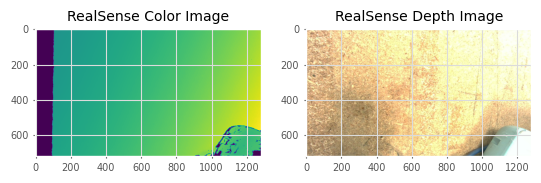

Masks


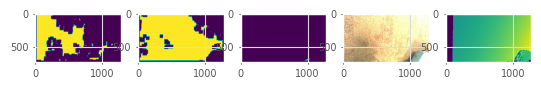

Depth Images (Segmented)


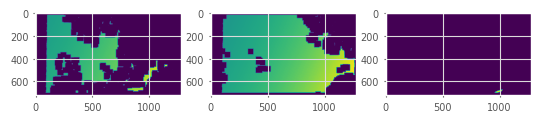

RGBD Depth Images)


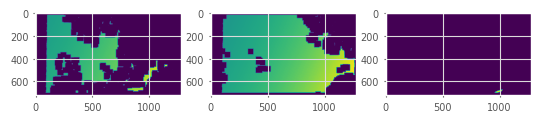

Extrinsics: [[ 2.12990044e-05 -9.60396581e-01  2.78636693e-01 -6.59167507e-01]
 [-9.92523655e-01  3.39879802e-02  1.17224618e-01 -1.23894608e-01]
 [-1.22052420e-01 -2.76556006e-01 -9.53215601e-01 -2.34255261e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
transform
: [[ 2.12990044e-05 -9.92523655e-01 -1.22052420e-01 -1.51545711e-01]
 [-9.60396581e-01  3.39879802e-02 -2.76556006e-01 -6.93635991e-01]
 [ 2.78636693e-01  1.17224618e-01 -9.53215601e-01 -2.51040169e-02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[Open3D DEBUG] Add geometry and update bounding box to [(-0.0150, -0.0150, -0.0150) - (0.2500, 0.2500, 0.2500)]
[Open3D DEBUG] Add geometry and update bounding box to [(-0.3997, -0.9337, -0.2634) - (0.2500, 0.2500, 0.2500)]
[Open3D DEBUG] Add geometry and update bounding box to [(-0.3997, -0.9337, -0.2634) - (0.2500, 0.2500, 0.2500)]
[Open3D DEBUG] Add geometry and update bounding box to [(-0.3997, -0.9444, -0.2634) - (0.2500, 0.2500,

In [10]:
def runRoutine():
    print("1")
    try:
        ur = UR5_Interface()
        ur.c = con
        ur.r = rec
    except Exception as e:
        raise(e)
        
    print("2")
    robot_model = RTB_Model()
    robot_model.setJointAngles(ur.getJointAngles())
    # Set joint angles so object detection has correct extrinsics
    detector = ObjectDetection(robot_model)
    
    try:
        pcd,rgbdImage = detector.real.getPCD()
        # rgbdImage = detector.real.takeImages()
        depthImage,colorImage = rgbdImage.depth,rgbdImage.color
        detector.real.displayImages(depthImage,colorImage)
        redPCD,yellowPCD,bluePCD = detector.colorSegmentation(colorImage,depthImage)
        # detector.real.displayPCD([pcd])
        detector.real.displayPCD([redPCD,yellowPCD,bluePCD])
        blueBlock = Block("Blue Block",bluePCD)
        detector.real.displayPCD([bluePCD,blueBlock.blockAABB])
        '''
        blocks = [Block("Red Block",redPCD),Block("Yellow Block",yellowPCD),Block("Blue Block",bluePCD)]
        items = []
        for block in blocks:
            s = o3d.geometry.TriangleMesh.create_sphere(radius=0.0125/4)
            s.translate(block.getGraspPoint())
            items.extend([block.blockPCD,block.blockAABB,s])
        detector.real.displayPCD(items)
        '''
        m = MotionPlanner([blueBlock])
        m.ur = ur
        m.rtb_model = robot_model
        m.runMovement()
        # m.display()
        # o3d.io.write_point_cloud("redPCD.pcd",redPCD)
    except Exception as e:
        raise(e)
    finally:
        detector.real.pipe.stop()
        ur.c.disconnect()
        ur.r.disconnect()
runRoutine()

robot_model = RTB_Model()
robot_model.plotRobot()
x,y,z = [],[],[]
for point in redPCD.points:
    x.append(point[0])
    y.append(point[1])
    z.append(point[2])

print(np.mean(x))
print(np.mean(y))
print(np.mean(z))
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(x,y,z)
plt.show()

In [20]:
(real.extrinsics is None) == False

True